In [1]:
import xarray as xr
import zipfile
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from xarray.coders import CFDatetimeCoder

### Unzip CDS files

In [9]:
# Copy this list from respective file
models = [
    "access_cm2",
    "awi_cm_1_1_mr",
    "canesm5",
    "canesm5_canoe",
    "cesm2",
    "cesm2_waccm",
    "cmcc_cm2_sr5",
    "cnrm_cm6_1",
    "cnrm_cm6_1_hr",
    "cnrm_esm2_1",
    "ec_earth3_aerchem",
    "ec_earth3_veg_lr",
    "fgoals_f3_l",
    "fgoals_g3",
    "gfdl_esm4",
    "iitm_esm",
    "inm_cm4_8",
    "inm_cm5_0",
    "ipsl_cm5a2_inca",
    "ipsl_cm6a_lr",
    "kace_1_0_g",
    "mcm_ua_1_0",
    "miroc6",
    "miroc_es2l",
    "mpi_esm1_2_lr",
    "mri_esm2_0",
    "noresm2_mm",
    "taiesm1",
    "ukesm1_0_ll"
]

ddir = "/global/cfs/cdirs/m1199/skygale/ssp370/"

for model in models:
    zip_path = os.path.join(ddir, f"{model}_2015_2022.zip")

    if not os.path.exists(zip_path):
        print(f"Missing: {zip_path}")
        continue

    if not zipfile.is_zipfile(zip_path):
        print(f"Not a zip file: {zip_path}")
        continue

    print(f"Extracting {zip_path}")

    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(ddir)

Extracting /global/cfs/cdirs/m1199/skygale/ssp370/access_cm2_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/awi_cm_1_1_mr_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/canesm5_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/canesm5_canoe_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cesm2_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cesm2_waccm_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cmcc_cm2_sr5_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cnrm_cm6_1_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cnrm_cm6_1_hr_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/cnrm_esm2_1_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/ec_earth3_aerchem_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/ec_earth3_veg_lr_2015_2022.zip
Extracting /global/cfs/cdirs/m1199/skygale/ssp370/fgoals_f3_l_2015_2022.zip
Extrac

### Build file indices

In [2]:
def index_by_model_member(file_list):
    index = {}
    for f in file_list:
        ds = xr.open_dataset(f, decode_times=True)
        model = ds.attrs.get("source_id")
        member = ds.attrs.get("variant_label")
        index[(model, member)] = f
        ds.close()
    return index


main_dir = "/global/cfs/cdirs/m1199/skygale/"

hist_files   = glob.glob(os.path.join(main_dir, "historical/*.nc"))
ssp585_files = glob.glob(os.path.join(main_dir, "ssp585/*.nc"))
ssp370_files = glob.glob(os.path.join(main_dir, "ssp370/*.nc"))

hist_index   = index_by_model_member(hist_files)
ssp585_index = index_by_model_member(ssp585_files)
ssp370_index = index_by_model_member(ssp370_files)

### Splice logic

In [3]:
os.makedirs(os.path.join(main_dir, "spliced"), exist_ok=True)

models = []
for (model, member), hist_file in hist_index.items():

    # Choose SSP
    if (model, member) in ssp585_index:
        ssp_file = ssp585_index[(model, member)]
        scenario = "ssp585"
    elif (model, member) in ssp370_index:
        ssp_file = ssp370_index[(model, member)]
        scenario = "ssp370"
    else:
        print(f"  ❌ Skipping {model} {member}: no SSP found")
        continue

    print(f"✅ Merging {model} {member} using {scenario}")
    models.append(model)

    ds_hist = xr.open_dataset(hist_file, decode_times=True)
    ds_ssp = xr.open_dataset(ssp_file, decode_times=True)

    # Concatenate
    ds_merged = xr.concat(
        [ds_hist, ds_ssp],
        dim="time",
        data_vars="minimal",
        coords="minimal",
        compat="override",
        join="override"
    )

    # Sort time just in case
    ds_merged = ds_merged.sortby("time")

    outfile = os.path.join(main_dir, f"spliced/{model}_{member}_1980_2022.nc")
    ds_merged.to_netcdf(outfile)

    ds_hist.close()
    ds_ssp.close()
    ds_merged.close()

print("Done.")

✅ Merging CMCC-CM2-SR5 r1i1p1f1 using ssp585
  ❌ Skipping NorCPM1 r1i1p1f1: no SSP found
✅ Merging ACCESS-CM2 r1i1p1f1 using ssp585
  ❌ Skipping CESM2-WACCM-FV2 r1i1p1f1: no SSP found
✅ Merging AWI-CM-1-1-MR r1i1p1f1 using ssp585
✅ Merging CMCC-ESM2 r1i1p1f1 using ssp585
✅ Merging CNRM-ESM2-1 r1i1p1f2 using ssp585
✅ Merging INM-CM5-0 r1i1p1f1 using ssp585
✅ Merging MIROC-ES2L r1i1p1f2 using ssp585
✅ Merging CanESM5-CanOE r1i1p2f1 using ssp585
✅ Merging MIROC6 r1i1p1f1 using ssp585
  ❌ Skipping MIROC-ES2H r1i1p4f2: no SSP found
✅ Merging HadGEM3-GC31-MM r1i1p1f3 using ssp585
  ❌ Skipping GISS-E2-1-H r1i1p1f1: no SSP found
✅ Merging CanESM5 r1i1p1f1 using ssp585
✅ Merging KIOST-ESM r1i1p1f1 using ssp585
✅ Merging UKESM1-0-LL r1i1p1f2 using ssp585
  ❌ Skipping CMCC-CM2-HR4 r1i1p1f1: no SSP found
✅ Merging IPSL-CM5A2-INCA r1i1p1f1 using ssp370
✅ Merging IITM-ESM r1i1p1f1 using ssp585
✅ Merging FGOALS-g3 r1i1p1f1 using ssp585
✅ Merging FIO-ESM-2-0 r1i1p1f1 using ssp585
✅ Merging MRI-ESM2-0 

### Multi-model mean

In [4]:
def ensemble_mean(model):
    files = glob.glob(os.path.join(os.path.join(main_dir, "spliced"), f"{model}_*.nc"))
    if not files:
        print(f"No files found for {model}")
        return None

    time_coder = CFDatetimeCoder(use_cftime=True)    
    ds = xr.open_mfdataset(files, combine="nested", concat_dim="member", decode_times=time_coder)
    
    # Zonal mean
    ds_zonal = ds.mean("lon")
    
    # Ensemble mean
    ds_mean = ds_zonal.mean("member")
    
    return ds_mean


model_means = []
for model in models:
    print(f"Processing {model}...")
    ds_mean = ensemble_mean(model)
    if ds_mean is not None:
        model_means.append(ds_mean)

# Convert cftime to numeric years
numeric_model_means = []
for ds_mean in model_means:
    time_numeric = np.array([
        t.year + (t.month-0.5)/12 for t in ds_mean.time.values
    ])
    ds_mean = ds_mean.assign_coords(time=time_numeric)
    numeric_model_means.append(ds_mean)

# Drop unnecessary variables and overwrite the list
numeric_model_means = [
    ds.ta.drop_vars([v for v in ds.data_vars if 'bnds' in v or 'axis_nbounds' in v], errors='ignore')
    for ds in numeric_model_means
]

print("Done.")

Processing CMCC-CM2-SR5...
Processing ACCESS-CM2...
Processing AWI-CM-1-1-MR...
Processing CMCC-ESM2...
Processing CNRM-ESM2-1...
Processing INM-CM5-0...
Processing MIROC-ES2L...
Processing CanESM5-CanOE...
Processing MIROC6...
Processing HadGEM3-GC31-MM...
Processing CanESM5...
Processing KIOST-ESM...
Processing UKESM1-0-LL...
Processing IPSL-CM5A2-INCA...
Processing IITM-ESM...
Processing FGOALS-g3...
Processing FIO-ESM-2-0...
Processing MRI-ESM2-0...
Processing INM-CM4-8...
Processing HadGEM3-GC31-LL...
Processing CESM2-WACCM...
Processing EC-Earth3-AerChem...
Processing NorESM2-MM...
Processing CNRM-CM6-1...
Processing CIESM...
Processing CNRM-CM6-1-HR...
Processing TaiESM1...
Processing MPI-ESM1-2-LR...
Processing FGOALS-f3-L...
Processing GFDL-ESM4...
Processing EC-Earth3-Veg-LR...
Processing EC-Earth3-CC...
Processing KACE-1-0-G...
Processing IPSL-CM6A-LR...
Processing NESM3...
Done.


In [5]:
# Interpolate to common grids
plev_common = np.array(
    [
        100000., 92500., 85000., 70000., 60000., 50000.,
        40000., 30000., 25000., 20000., 15000., 10000.,
        7000., 5000., 3000., 2000., 1000., 500., 100.
    ]
)
lat_common = np.arange(0, 91, 2.5)

numeric_model_means_interp = [
    ds.interp(
        plev=plev_common,
        lat=lat_common,
        method="linear"
    )
    for ds in numeric_model_means
]

# Concatenate
mmm = xr.concat(numeric_model_means_interp, dim="model", join="inner").mean("model")
mmm

<xarray.DataArray 'ta' (time: 129, plev: 19, lat: 37)> Size: 363kB
dask.array<mean_agg-aggregate, shape=(129, 19, 37), dtype=float32, chunksize=(1, 7, 37), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 1kB 1.98e+03 1.98e+03 ... 2.022e+03 2.022e+03
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 296B 0.0 2.5 5.0 7.5 10.0 ... 82.5 85.0 87.5 90.0
Attributes:
    standard_name:  air_temperature
    long_name:      Air Temperature
    comment:        Air Temperature
    units:          K
    original_name:  T (using vinth2p_ecmwf)
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2020-05-27T09:12:46Z altered by CMOR: Converted type from...

### Compute trend

In [12]:
# Map fractional years to months
month_map = {
    0.208333: "March",
    0.291667: "April",
    0.375000: "May"
}

# Assign month labels
months = [month_map[np.round(t % 1, 6)] for t in mmm.time.values]  # round to avoid floating point issues
mmm = mmm.assign_coords(month=("time", months))

# Compute trend for each month (K/decade)
trends = {}
for mon in ["March", "April", "May"]:
    ds_mon = mmm.sel(time=mmm.month == mon)

    trend_mon = (
        ds_mon
        .polyfit(dim="time", deg=1)["polyfit_coefficients"]
        .sel(degree=1)
        * 10
    )
    
    trends[mon] = trend_mon

# Access trend for each month
march_trend = trends["March"] * (0.213/0.260)
april_trend = trends["April"] * (0.213/0.260)
may_trend   = trends["May"] * (0.213/0.260)

march_trend

<xarray.DataArray 'polyfit_coefficients' (plev: 19, lat: 37)> Size: 6kB
dask.array<mul, shape=(19, 37), dtype=float64, chunksize=(7, 37), chunktype=numpy.ndarray>
Coordinates:
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 296B 0.0 2.5 5.0 7.5 10.0 ... 82.5 85.0 87.5 90.0
    degree   int64 8B 1

In [13]:
# Save scaled trends
ds = xr.Dataset(
    {
        "march_trend": march_trend,
        "april_trend": april_trend,
        "may_trend": may_trend,
    }
)

ds.to_netcdf("./data/scaled_MMM_Vertical_Temp.nc")

### Plot

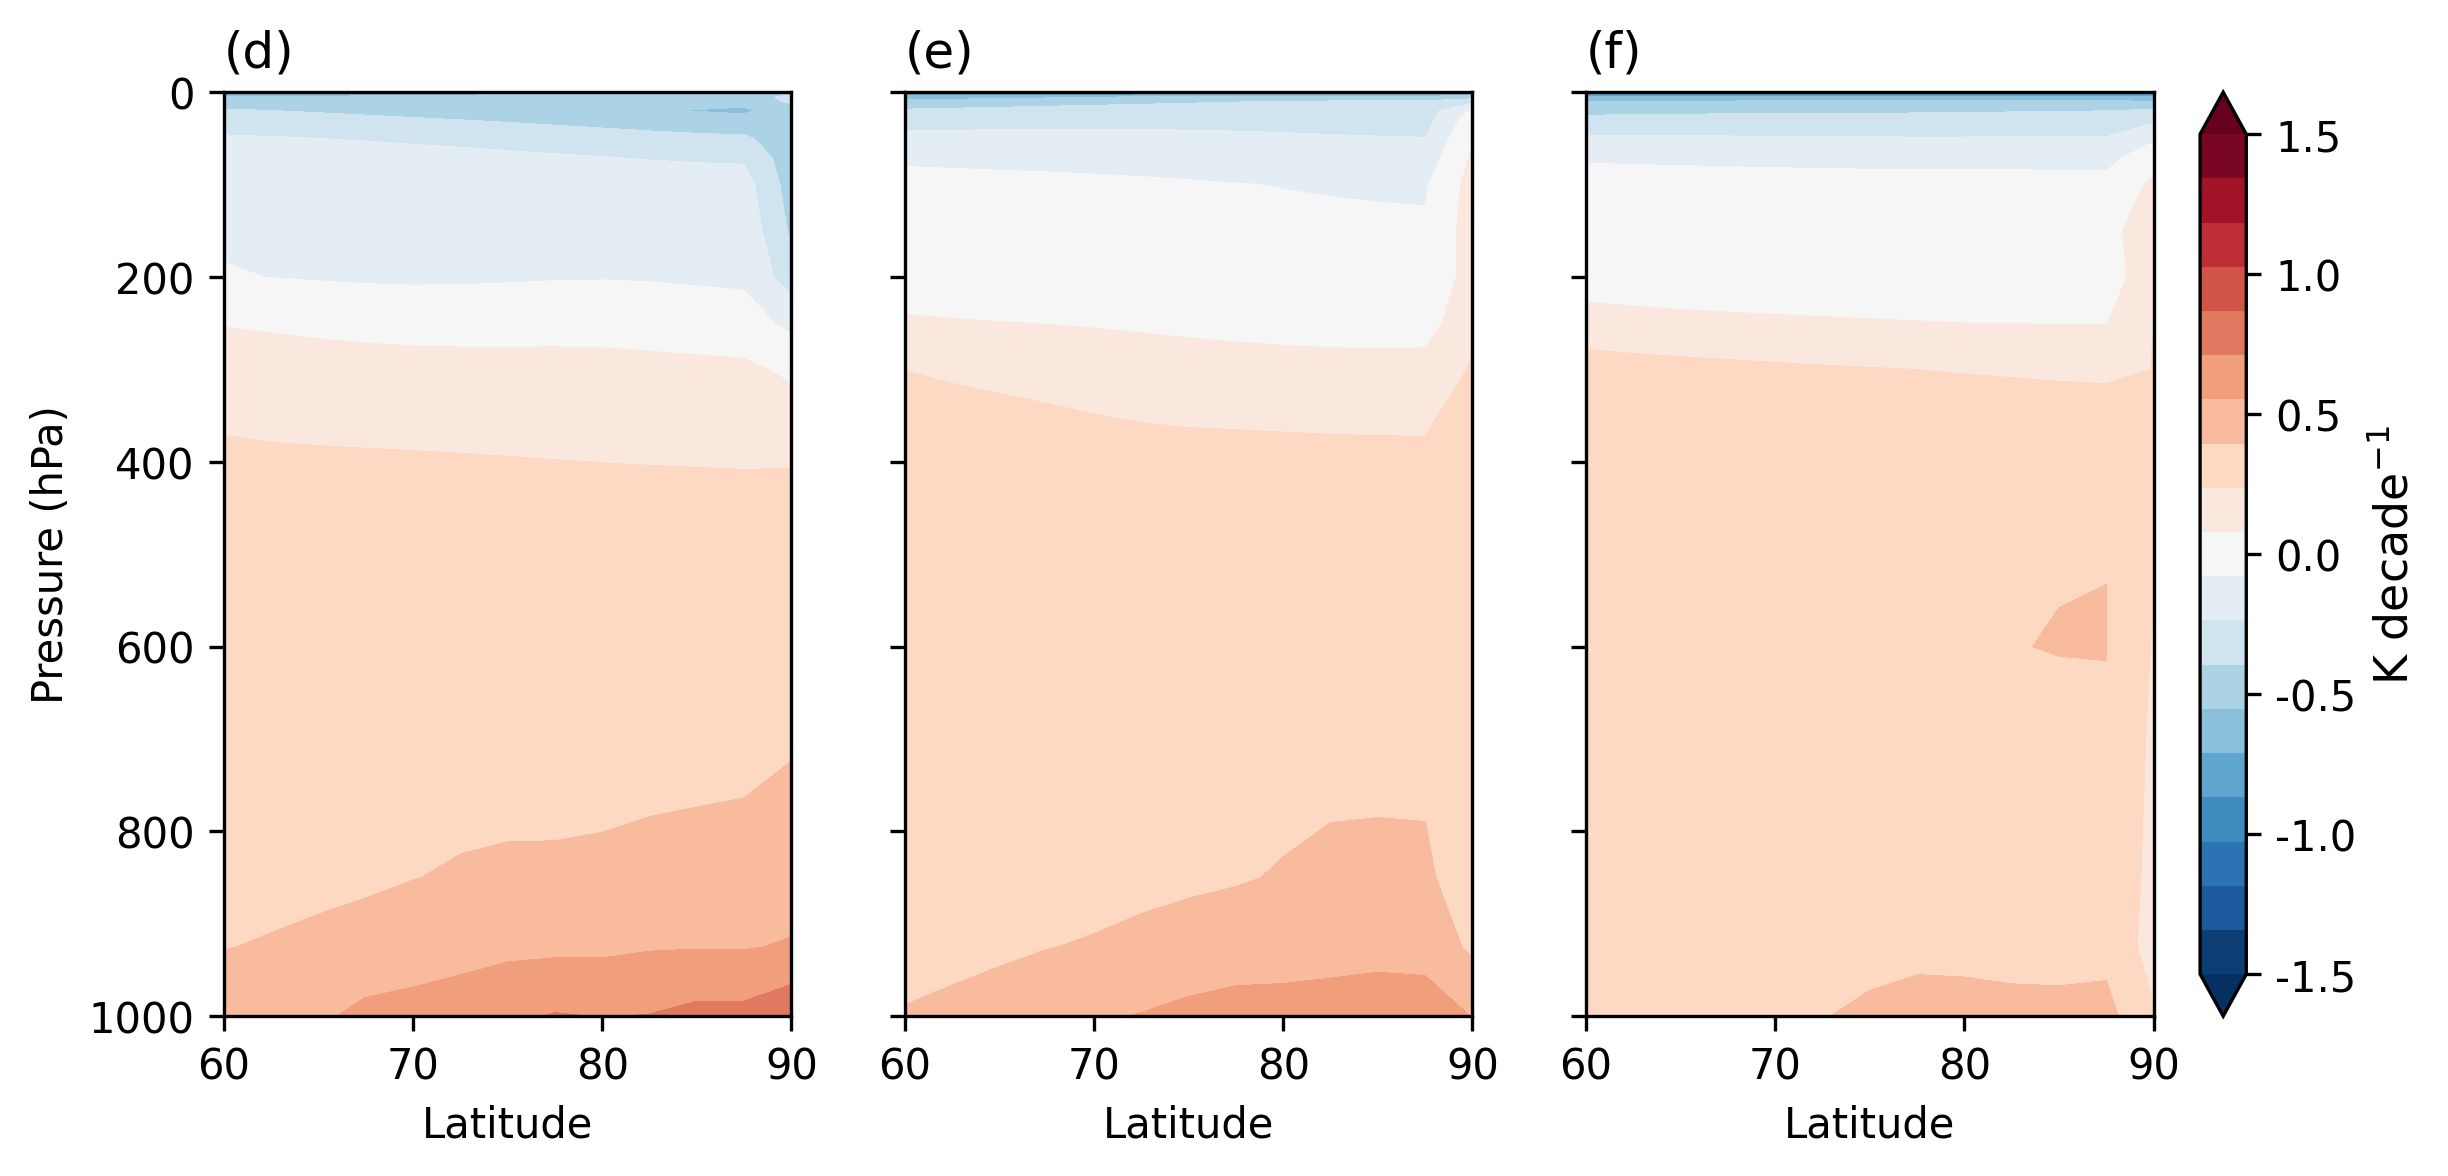

In [18]:
levels = np.linspace(-1.5, 1.5, 20)
plevs = march_trend.plev.values / 100
lats = march_trend.lat.values

fig, axes = plt.subplots(1, 3, figsize=(10, 4), dpi=300, sharey=True)

def plot_profile(ax, data, title, cmap=None, levels=None, lats=None):
    cf = ax.contourf(lats, plevs, data, cmap=cmap, levels=levels, extend='both')
    ax.set_xlim(60, 90)
    ax.invert_yaxis()
    ax.set_xlabel('Latitude')
    ax.set_title(title, loc='left')
    return cf

plot_profile(axes[0], march_trend, '(d)', cmap='RdBu_r', levels=levels, lats=lats)
plot_profile(axes[1], april_trend, '(e)', cmap='RdBu_r', levels=levels, lats=lats)
cf = plot_profile(axes[2], may_trend, '(f)', cmap='RdBu_r', levels=levels, lats=lats)

# Colorbar
custom_ticks = [-1.5, -1, -0.5, 0, 0.5, 1, 1.5]
cbar = fig.colorbar(cf, ax=axes.ravel(), orientation='vertical', extend='both', pad=0.02)
cbar.set_ticks(custom_ticks)
cbar.set_ticklabels([f"{t:.1f}" for t in custom_ticks])
cbar.set_label('K decade$^{-1}$', fontsize=11)
cbar.ax.tick_params(labelsize=10)

axes[0].set_ylabel('Pressure (hPa)')
axes[0].set_ylim(1000, 1)
plt.savefig('./figures/Figure5b.png', dpi=300, bbox_inches='tight')
plt.show()